In [288]:
import yfinance as yf
bist100=yf.Ticker("ALFAS.IS")
bist100 =bist100.history(period="max")

<Axes: title={'center': 'BIST100'}, xlabel='Date'>

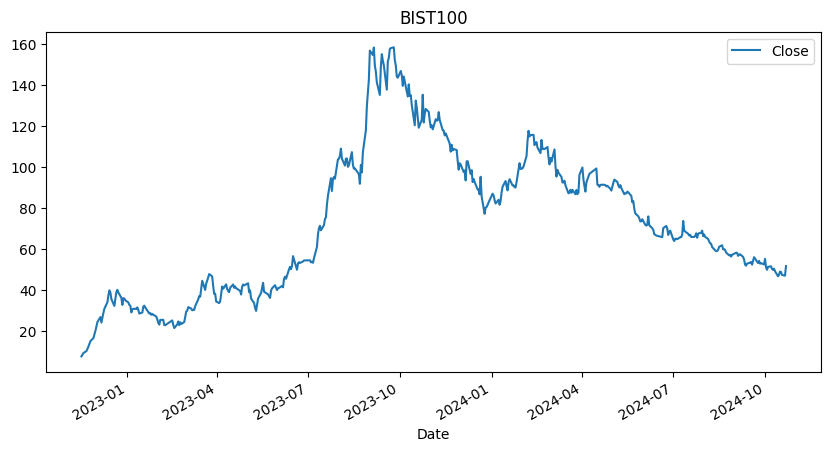

In [289]:
bist100.plot.line(y='Close',title='BIST100',figsize=(10,5),use_index=True)

In [290]:
del bist100["Dividends"]
del bist100["Stock Splits"]
bist100["Tomorrow"]=bist100["Close"].shift(-1)
bist100["Target"]=(bist100["Tomorrow"]>bist100["Close"]).astype(int)
bist100

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2022-11-16 00:00:00+03:00,7.845178,7.845178,7.845178,7.845178,168480,8.625429,1
2022-11-17 00:00:00+03:00,8.625429,8.625429,8.625429,8.625429,260776,9.484924,1
2022-11-18 00:00:00+03:00,9.484924,9.484924,9.484924,9.484924,1217584,10.429759,1
2022-11-21 00:00:00+03:00,10.429759,10.429759,10.429759,10.429759,1968792,11.472125,1
2022-11-22 00:00:00+03:00,11.472125,11.472125,11.472125,11.472125,1595352,12.618119,1
...,...,...,...,...,...,...,...
2024-10-16 00:00:00+03:00,47.680000,49.139999,47.180000,49.139999,1462961,48.959999,0
2024-10-17 00:00:00+03:00,49.139999,49.299999,48.520000,48.959999,1460446,47.520000,0
2024-10-18 00:00:00+03:00,48.959999,49.340000,47.520000,47.520000,1048102,47.119999,0


In [291]:
bist100=bist100.loc["2000-01-01":].copy()

In [292]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)
train =bist100.iloc[:-100].copy()
test =bist100.iloc[-100:].copy()
predictors=["Close", "Volume", "High", "Low"]
model.fit(train[predictors],train["Target"])
from sklearn.metrics import precision_score
preds=model.predict(test[predictors])
import pandas as pd
preds=pd.Series(preds,index=test.index)
precision_score(test["Target"],preds)


0.47674418604651164

<Axes: xlabel='Date'>

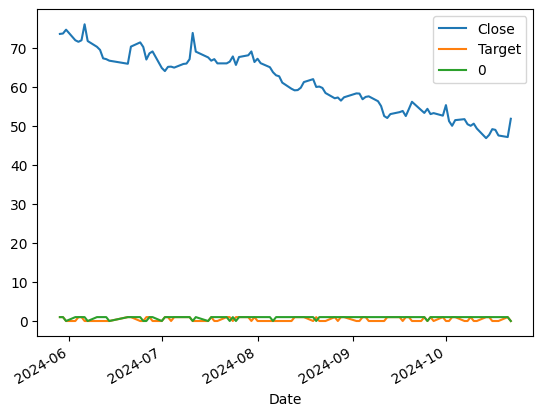

In [293]:
combined=pd.concat([test["Close"],test["Target"],preds],axis=1)
combined.plot()

In [294]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Close"], test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=1, step=50):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:i+step].copy()
        preds = predict(train, test, predictors, model)
        all_predictions.append(preds)
        print(f"Appended predictions for step {i} to {i+step}")
    if not all_predictions:
        print("No predictions were made.")
    return pd.concat(all_predictions)

# Assuming bist100 and predictors are defined
try:
    predictions = backtest(bist100, model, predictors)
    print(predictions["Predictions"].value_counts())
except ValueError as e:
    print(f"Error: {e}")

Appended predictions for step 1 to 51
Appended predictions for step 51 to 101
Appended predictions for step 101 to 151
Appended predictions for step 151 to 201
Appended predictions for step 201 to 251
Appended predictions for step 251 to 301
Appended predictions for step 301 to 351
Appended predictions for step 351 to 401
Appended predictions for step 401 to 451
Appended predictions for step 451 to 501
Predictions
1    409
0     72
Name: count, dtype: int64


In [295]:
precision_score(predictions["Target"],predictions["Predictions"])
predictions["Target"].value_counts()/predictions.shape[0]

Target
0    0.505198
1    0.494802
Name: count, dtype: float64

In [296]:
horizons=[2,5,60,250,1000]
new_predictors=[]
for horizon in horizons:
    rolling_averages=bist100["Close"].rolling(window=horizon).mean()
    
    ratio_columnn=f"Close_Ratio_{horizon}"
    bist100[ratio_columnn]=bist100["Close"]/rolling_averages
    
    trend_column=f"Trend_{horizon}"
    bist100[trend_column]=bist100.shift(1).rolling(horizon).sum()["Target"]
    new_predictors+= [ratio_columnn,trend_column]

In [297]:
bist100=bist100.dropna()

In [298]:
model=RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Close"], test["Target"], preds], axis=1)
    print(f"Predictions made for test set: {preds.head()}")
    return combined

def backtest(data, model, predictors, step=400):
    all_predictions = []
    
    for i in range(step, data.shape[0], step):
        print(f"Processing step {i} to {i+step}")
        train = data.iloc[:i].copy()
        test = data.iloc[i:i+step].copy()
        if train.empty or test.empty:
            print(f"Empty train or test set for step {i} to {i+step}")
            continue
        preds = predict(train, test, predictors, model)
        all_predictions.append(preds)
        print(f"Appended predictions for step {i} to {i+step}")
    
    if not all_predictions:
        print("No predictions were made.")
    return pd.concat(all_predictions)

# Assuming bist100 and new_predictors are defined
try:
    predictions = backtest(bist100, model, new_predictors)
    print(predictions["Predictions"].value_counts())
except ValueError as e:
    print(f"Error: {e}")

No predictions were made.
Error: No objects to concatenate


In [299]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5061124694376528